In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os

First we started by importing the necessary libraries.

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

We used the `tf.config.experimental.list_physical_devices('GPU')` to check for all the available GPUs. 

We then used the `tf.config.experimental.set_memory_growth` to set the memory growth to true. 

This is done to avoid the memory allocation errors.

# Loading Data

In [3]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 545 files belonging to 2 classes.


We used the `tf.keras.preprocessing.image_dataset_from_directory` to load the data from the directory.

In [4]:
data.class_names

['TCImages', 'TSImages']

We have two classes of images which are `TCImages` and `TSImages` which are the images generated by the eye tracking device.

The `TCImages` refers to Non-ASD class and `TSImages` refers to ASD class.

In [5]:
data_iterator = data.as_numpy_iterator()

We used the `as_numpy_iterator` to convert the data into numpy array.

In [6]:
batch = data_iterator.next()

Then we loaded the data as batches of 32 images into the `batch` variable.

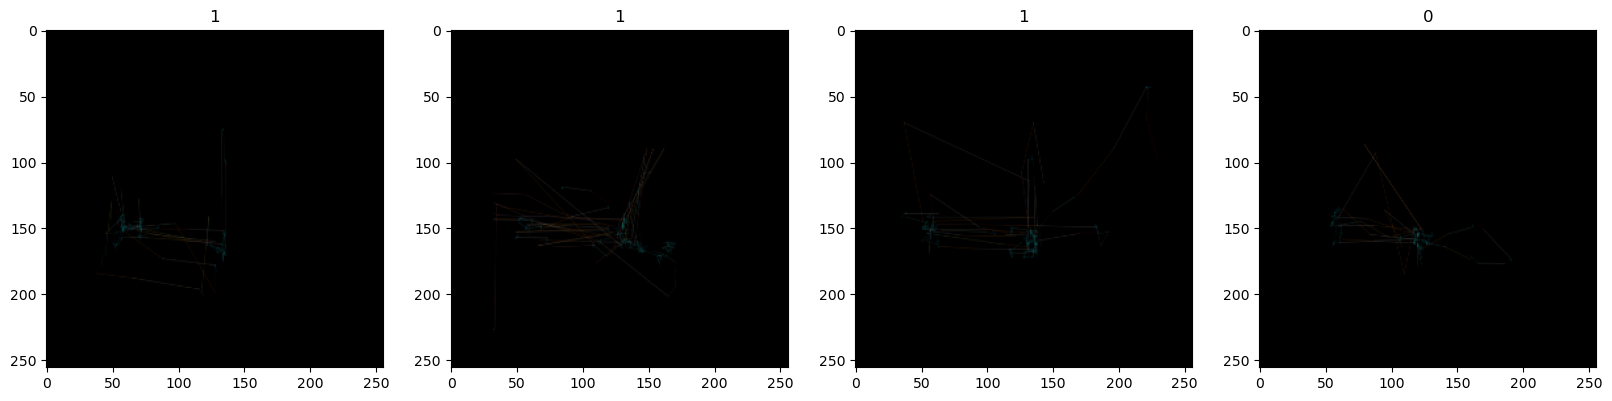

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Here we visiualized 4 images of the first batch using the `matplotlib` library.

In [8]:
batch[0].shape

(32, 256, 256, 3)

Each batch of the data consists of 32 images of width and height equal 256 pixels. The images are divided into 3 channels (RGB). The data is loaded using the `tf.data` API.

In [9]:
batch[0].max()

110.09375

Our data is in the range of [0, 255]. We need to scale it to the range of [0, 1] to feed it to the model.

# Scaling The Data

In [10]:
data = data.map(lambda x,y: (x/255, y))

We used the `map` function from the `tf.data` API to scale the data.

In [11]:
scaled_iterator = data.as_numpy_iterator()

In [12]:
batch = scaled_iterator.next()

In [13]:
batch[0].max()

0.44381127

Here we can see that the maximum value of the data is between 1.0 and 0.0 which means that the data is scaled.

In [14]:
batch[0].min()

0.0

Our data is now scaled to the range of [0, 1].

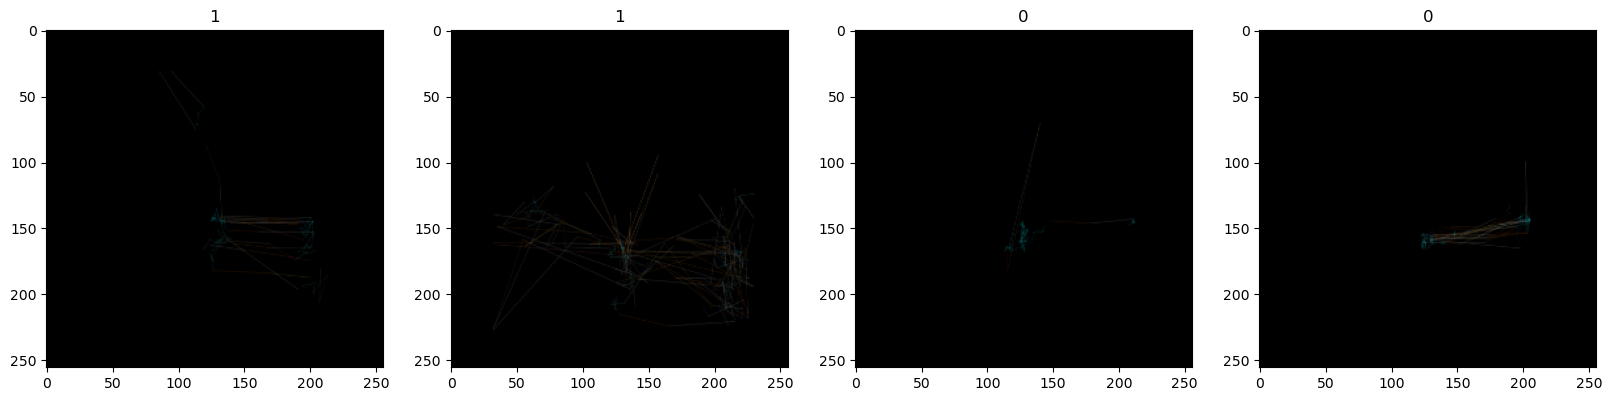

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

We visiualized the first 4 images of the first batch after scaling to check if the data is scaled correctly.

# Spliting The Data

In [16]:
tf.keras.utils.image_dataset_from_directory?

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Docstring:
Generates a `tf.data.Dataset` from image files in a directory.

If your directory structure is:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

Then calling `image_dataset_from_directory(main_directory,
labels='inferred')` will return a `tf.data.Dataset` that yields batches of
images from the subdirectories `class_a` and `class_b`, together with labels
0 and 1 (0 corresponding to `class_a` and 1 corresponding to `class_b`).

Supported image formats: `.jpeg`, `.jpg`, `.png`, `.bmp`, `.gif`.
Animated gifs are truncated

As we see, the shuffle is set to `True` by default in the `tf.keras.utils.image_dataset_from_directory` function 

so we don't need to shuffle the data again and we can directly split it into training, validation and testing sets.

In [17]:
len(data)

18

We have 545 images that are devided into 18 batches , one of them will get turnicated so we are left with 17 batches.

Each batch has 32 images. We will use 12 batches for training, 2 batches for validation and 1 batch for testing.

In [18]:
train_size = 12 #    ≈ 70%
val_size = 3    #    ≈ 20%
test_size = 2   #    ≈ 10%

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

Here we used the `take` and `skip` methods to split the data, the `take` method takes the data that we specify and the `skip` method skips the data that we already took.

In [20]:
len(train), len(val), len(test)

(12, 3, 2)

The batches were assigned correctly to the `training`, `validation` and `testing` sets.

# Building The CNN Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

First we started by importing the Sequential model from the `tf.keras.models` API.

Then we imported the Conv2D, MaxPooling2D, Flatten and Dense layers from the `tf.keras.layers` API.

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3, 3), strides=1, padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

We used the `Sequential` model to build our CNN model which is a stack of layers where each layer has exactly one input tensor and one output tensor.

We used three `Conv2D` layer to create a convolutional layer that will generate 16, 32, 16 filters for each image with a kernel size of 3x3 and a stride of 1x1.

We used the `MaxPooling2D` layer to create a pooling layer that will downsample the input representation by taking the maximum value over the window defined by pool_size for each dimension along the features axis.

We used the `Flatten` layer to flatten the input. 

We used the `Dense` layer to create a fully connected layer that will generate 256 neurons.

We used the `Dropout` layer to create a dropout layer that will randomly drop 20% of the neurons to avoid overfitting.

We used the `Dense` layer to create a fully connected layer that will generate 1 neuron with a sigmoid activation function to classify the images into two classes.

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

We used the `adam` optimizer and the `BinaryCrossentropy()` loss function.

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 16)        0

This is the summary of our model.

# Training The Model

In [26]:
logdir='logs'

Here we created a log directory to store the logs of the training process.

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

We used the `tf.keras.callbacks.TensorBoard` to create a TensorBoard callback to visualize the logs.

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20




12/12 [==============================] - 5s 299ms/step - loss: 0.6247 - accuracy: 0.6250 - val_loss: 0.4883 - val_accuracy: 0.7396
Epoch 2/20
12/12 [==============================] - 4s 318ms/step - loss: 0.5057 - accuracy: 0.7552 - val_loss: 0.4507 - val_accuracy: 0.7917
Epoch 3/20
12/12 [==============================] - 4s 308ms/step - loss: 0.4679 - accuracy: 0.7630 - val_loss: 0.4063 - val_accuracy: 0.7917
Epoch 4/20
12/12 [==============================] - 4s 291ms/step - loss: 0.4274 - accuracy: 0.7995 - val_loss: 0.4047 - val_accuracy: 0.8438
Epoch 5/20
12/12 [==============================] - 4s 288ms/step - loss: 0.3932 - accuracy: 0.8151 - val_loss: 0.3667 - val_accuracy: 0.8854
Epoch 6/20
12/12 [==============================] - 4s 287ms/step - loss: 0.3658 - accuracy: 0.8307 - val_loss: 0.3162 - val_accuracy: 0.8750
Epoch 7/20
12/12 [==============================] - 4s 289ms/step - loss: 0.3323 - accuracy: 0.8568 - val_loss: 0.2788 - val_accuracy: 0.8750
Epoch 8/20
12/12

Here we used the `model.fit` function to train the model.

# Plotting Performance

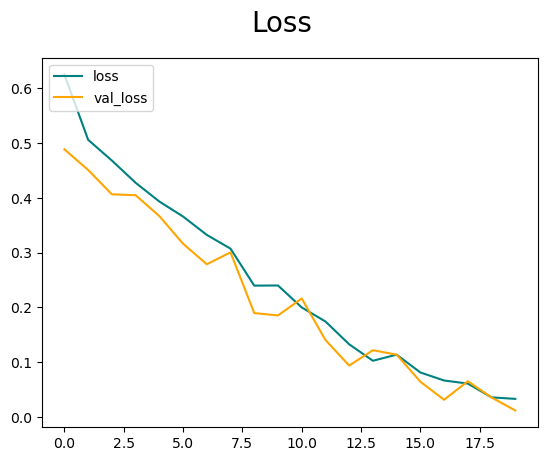

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Here we used the `matplotlib` library to plot the training and validation loss.

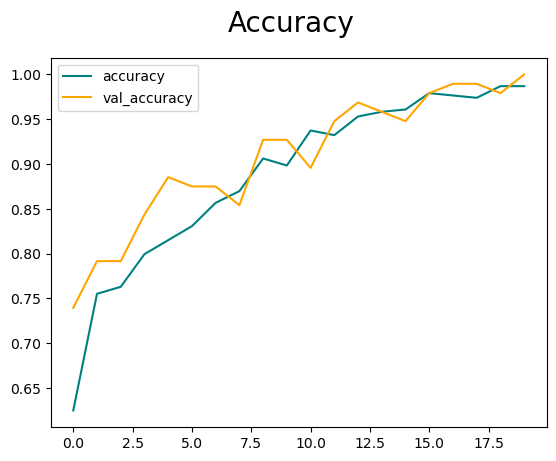

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

And we used the `matplotlib` library again to plot the training and validation accuracy.

# Evaluating The Model

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

We started our evaluation by importing the `tensorflow.keras.metrics` API.

For the evaluation we will use Precision, Recall and BinaryAccuracy.

In [32]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [33]:
y_all = []
yhat_all = []

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)

    y_all = y_all + list(y)
    yhat_all = yhat_all + list(yhat.round())
    
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 71ms/step


We used the `model.predict` function to predict the classes of the testing set.

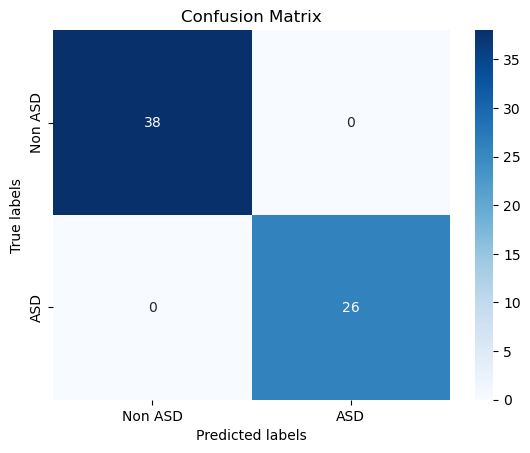

In [35]:
from sklearn.metrics import confusion_matrix


conf_mat = confusion_matrix(y_all,yhat_all)

ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax, cmap='Blues');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non ASD', 'ASD']); ax.yaxis.set_ticklabels(['Non ASD', 'ASD']);

We used the `confusion_matrix` function from the sklearn module to create a confusion matrix to evaluate the model.


In [36]:
from sklearn.metrics import classification_report

Then we used the `classification_report` function from the sklearn module to create a classification report to evaluate the model.

In [37]:
print(classification_report(y_all, yhat_all))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        26

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



And as we see, the model has a precision of 1.0, a recall of 1.0 and an accuracy of 1.0.

This means that the model has a perfect performance on the testing set.

In [38]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


# Testing The Model

Now we will test our model on a new image that we took out of the dataset before beginning the training process to see if our model can classify it correctly.

In [39]:
import cv2

First I started by importing the `cv2` library to read the image.


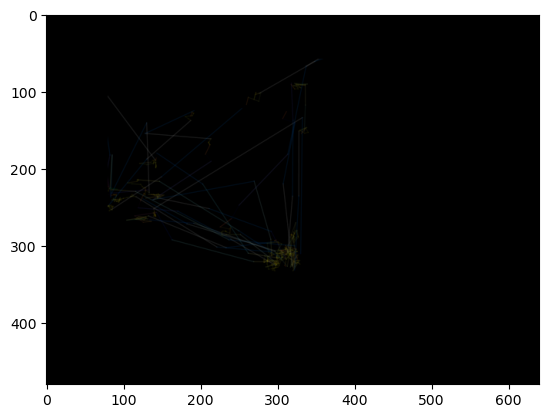

In [40]:
img = cv2.imread('TC082_49.png')
plt.imshow(img)
plt.show()

Then I used the `cv2.imread` function to read the image.

Then i used the `cv2.imshow` function to show the image.


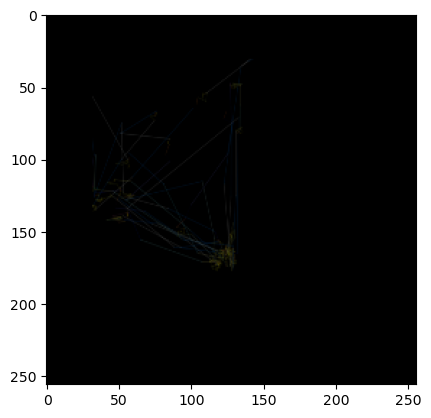

In [41]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

Then I used the `tf.image.resize()` to resize the image like I did in the scaling step.

In [42]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 100ms/step


Here we can see that the image is resized correctly.

Then I used the `np.expand_dims` function to add a new axis to the image.

Then I used the `model.predict` function to predict the class of the image.

In [43]:
yhat

array([[0.00851767]], dtype=float32)

In [44]:
if yhat > 0.5: 
    print(f'Predicted class is TSI')
else:
    print(f'Predicted class is TCI')

Predicted class is TCI


Here I used the `if` statement to set the scores to each class.

# Saving the Model

In [45]:
from tensorflow.keras.models import load_model

Then I called the `load_model` function from the `tensorflow.keras.models` API to load the model.

Then I used the `model.save` function to save the model.    

In [46]:
model.save(os.path.join('models','imageclassifier.h5'))

c:\Users\Abdul\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


As we can see, the model is saved successfully.

In [47]:
new_model = load_model('models\imageclassifier.h5')

Here I loaded the model again to make sure that it is saved correctly.

In [48]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 91ms/step


Then I used the `model.predict` function to predict the class of the image again.

In [49]:
if yhat_new > 0.5: 
    print(f'Predicted class is TSI')
else:
    print(f'Predicted class is TCI')

Predicted class is TCI


And here we can see that everything is working correctly.